In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from pathlib import Path
from collections import defaultdict

# Recurrent Neural Network

## Layers

### RNN Layer

[`nn.RNN`](https://pytorch.org/docs/stable/nn.html#rnn) needs following arguments.

* `input_size`: input size 
* `hidden_size`: hidden size
* `num_layers`: number of layers
* `nonlinearity`: activation function, default as tanh
* `batch_first`: if batch dimension come to first check it as True, default input size is `(T, B, input_size)`, if `True`, should give input size as `(B, T, input_size)`
* `bidirectional`: check if want to use bidirection RNN 

**single layer rnn**

In [2]:
input_size = 10
hidden_size = 20
rnn_layer = nn.RNN(input_size=input_size, 
                   hidden_size=hidden_size, 
                   batch_first=True)

In [3]:
rnn_layer.weight_ih_l0.size()

torch.Size([20, 10])

In [4]:
batch = 5
time_step = 4
inputs = torch.rand(batch, time_step, input_size)
hiddens = torch.zeros(1, batch, hidden_size)
outputs, hiddens = rnn_layer(inputs, hiddens)

# inputs: (B, T, I)
# outputs: (B, T, H)
# hiddens: (num_layer, B, H)

print(f"outputs: {outputs.size()}\nhiddens: {hiddens.size()}")

outputs: torch.Size([5, 4, 20])
hiddens: torch.Size([1, 5, 20])


**multi-layer rnn**

In [5]:
num_layers = 2
rnn_layer = nn.RNN(input_size=input_size, 
                   hidden_size=hidden_size, 
                   num_layers=num_layers,
                   batch_first=True)

In [6]:
inputs = torch.rand(batch, time_step, input_size)
outputs, hiddens = rnn_layer(inputs)

# inputs: (B, T, I)
# outputs: (B, T, H)
# hiddens: (num_layer, B, H)

print(f"outputs: {outputs.size()}\nhiddens: {hiddens.size()}")

outputs: torch.Size([5, 4, 20])
hiddens: torch.Size([2, 5, 20])


**bidirectional rnn**

In [7]:
bidirection = True
rnn_layer = nn.RNN(input_size=input_size, 
                   hidden_size=hidden_size, 
                   num_layers=num_layers,
                   batch_first=True,
                   bidirectional=bidirection)

In [8]:
inputs = torch.rand(batch, time_step, input_size)
outputs, hiddens = rnn_layer(inputs)

# inputs: (B, T, I)
# outputs: (B, T, H*2)
# hiddens: (num_layer*2, B, H)

print(f"outputs: {outputs.size()}\nhiddens: {hiddens.size()}")

outputs: torch.Size([5, 4, 40])
hiddens: torch.Size([4, 5, 20])


### LSTM Layer

In [9]:
lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
hiddens = torch.zeros(num_layers, batch, hidden_size)
cells = torch.zeros(num_layers, batch, hidden_size)

outputs, (hiddens, cells) = lstm_layer(inputs, (hiddens, cells))

# inputs: (B, T, I)
# outputs: (B, T, H)
# hiddens: (num_layer, B, H)
# cells: (num_layer, B, H)

print(f"outputs: {outputs.size()}\nhiddens: {hiddens.size()}\ncells: {cells.size()}")

outputs: torch.Size([5, 4, 20])
hiddens: torch.Size([2, 5, 20])
cells: torch.Size([2, 5, 20])


### GRU Layer

In [10]:
gru_layer = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
hiddens = torch.zeros(num_layers, batch, hidden_size)

outputs, hiddens = gru_layer(inputs, hiddens)

# inputs: (B, T, I)
# outputs: (B, T, H)
# hiddens: (num_layer, B, H)

print(f"outputs: {outputs.size()}\nhiddens: {hiddens.size()}")

outputs: torch.Size([5, 4, 20])
hiddens: torch.Size([2, 5, 20])


---

# Name Classifier

Use RNN to classify 5 countries("German", "United States", "Spain", "Korean", "Russian") names

## Sequential Data Processing

1. Split all data as single character
2. assign all character one unique number(including paddping, unknown)
3. each batch need same lenght ot tokens, to do it add '\<pad\>' to end of characters
    
    * `<unk>`: if a new letter is never seen in train data, it will refer to this token
    * `<pad>`: use it to match input size

    ```
    length = 15: 
    'D', 'i', 'e', 't', 'h', 'a', 'r', 'd', ' ', 'T', 'e', 'x', 't', 'o', 'r'

    length = 11 + 4: 
    'M', 'a', 'r', 'c', 'o', ' ', 'D', 'i', 'e', 't', 'z', '<pad>', '<pad>', '<pad>', '<pad>'
    ```

4. apply one hot encoding
    
    ```
    example: total character length = 5
    
    each index map to following vector
    
    0 = [1, 0, 0, 0, 0]
    1 = [0, 1, 0, 0, 0]
    2 = [0, 0, 1, 0, 0]
    3 = [0, 0, 0, 1, 0]
    4 = [0, 0, 0, 0, 1]
    ```

### Custom Dataset

Build a custom Dataset. must implement `__getitem__` and `__len__`

```python
class CustomDataset(Dataset):
    def __init__(self):
        # Load data & Preprocessing here
        self.x = list(range(10))
        
    def __getitem__(self, index):
        # return the matched index data
        return self.x[index]
        
    def __len__(self):
        # length of dataset
        return len(self.x)
```

In [11]:
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

class CustomDataset(Dataset):
    def __init__(self, path, fmt="\t", pad_idx=1, vocab_stoi=None, labels_stoi=None):
        # read files
        with Path(path).open(mode="r", encoding="utf-8") as file:
            datas = file.readlines()
        datas = [line.strip().lower().split(fmt) for line in datas]
        datas, labels = list(zip(*datas))
        datas = [list(d) for d in datas]
        self.pad_idx = pad_idx
        
        if (vocab_stoi is None) and (labels_stoi is None):
            self.vocab_stoi = defaultdict()           # dictionary
            self.vocab_stoi["<unk>"] = 0
            self.vocab_stoi["<pad>"] = self.pad_idx   # 1
        
            self.labels_stoi = defaultdict()  
            labels_unique = ["german", "united states", "spain", "korean", "russian"]
            for i, label in enumerate(labels_unique):
                self.labels_stoi[label] = i
        else:
            self.vocab_stoi = vocab_stoi
            self.labels_stoi = labels_stoi
        
        # create index
        for name in datas:
            for letter in name:
                letter = letter.lower()
                if self.vocab_stoi.get(letter) is None:
                    self.vocab_stoi[letter] = len(self.vocab_stoi)
        self.vocab_len = len(self.vocab_stoi)
        self.vector_matrix = torch.eye(self.vocab_len)
        
        # change string to numeric numbers
        datas = [list(map(self.vocab_stoi.get, name)) for name in datas]
        labels = list(map(self.labels_stoi.get, labels))
        
        self.datas = datas
        self.labels = labels
        self.classes = list(self.labels_stoi)
        self.vocab_itos = {v: k for k, v in self.vocab_stoi.items()}
        
    def __getitem__(self, index):
        # return the matched index data
        return self.datas[index], self.labels[index]
        
    def __len__(self):
        # length of dataset
        return len(self.datas)
    
    def custom_collate_fn(self, data):
        """
        data = [
            self.__getitem__(i) for i in range(batch_size)
        ]
        """
        # [(data1, label1), (data2, label2), ...] -> (data1, data2, ...), (label1, label2, ...)
        
        datas, labels = list(zip(*data))
        max_len = max([len(name) for name in datas])
        # pad all idx
        datas = [name + [self.pad_idx]*(max_len - len(name)) if len(name) < max_len else name for name in datas]
        datas = torch.stack([torch.stack([self.vector_matrix[idx] for idx in name]) for name in datas])
        return datas, torch.LongTensor(labels)

In [44]:
from pathlib import Path

path_txt = "./data/names/names_{}.tsv"
batch_size = 128
train_dataset = CustomDataset(path_txt.format("train"), fmt="\t")
test_dataset = CustomDataset(path_txt.format("test"), fmt="\t", 
                             vocab_stoi=train_dataset.vocab_stoi,
                             labels_stoi=train_dataset.labels_stoi)

train_loader = DataLoader(dataset=train_dataset,
                          collate_fn=train_dataset.custom_collate_fn,
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         collate_fn=test_dataset.custom_collate_fn,
                         batch_size=batch_size, 
                         shuffle=False)

In [13]:
for names, labels in train_loader:
    break
    
# Batch size, length of tokens, input_size(=length of total unique characters)
print(names.size(), labels.size())

torch.Size([128, 34, 166]) torch.Size([128])


## RNN Model

### Desing Network

* Input Size = (B, T, vocab_size)
* Output Size = (B, 5)
* Loss Function(`nn.CrossEntropyLoss`): Cross Entropy Loss
* Optimizer(`optim.Adam`): Adam
* RNN Layer: Use `nn.LSTM` to `self.lstm_layer`

In [14]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # forward propagation
        outputs, (hiddens, cells) = self.lstm_layer(x)
        # x: (B, T, I)
        # outputs: (B, T, H)
        # hiddens: (num_layer, B, H)
        # cells: (num_layer, B, H)
        last_hidden = hiddens[-1]  # (B, H)
        o = self.linear(last_hidden)
        
        return o

## Training Model

### Train function

In [15]:
def train(model, train_loader, loss_function, optimizer, print_step, device):
    # Training
    model.train()
    n_train = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        # 1) need to initialize for every trackable tensors
        optimizer.zero_grad()
        # 2) forward propagation
        output = model(data)
        # 3) calculate Loss
        loss = loss_function(output, target)
        # 4) back propagation
        loss.backward()
        # 5) update parameters
        optimizer.step()
        
        if batch_idx % print_step == 0:
            percentage = (batch_idx*train_loader.batch_size / n_train) * 100
            print(f" - [{percentage:.2f}%] train loss: {loss:.4f}")

### Validation 함수

In [16]:
def validation(model, test_loader, loss_function, device):
    # Validation
    model.eval()
    test_loss = 0
    correct = 0
    n_test = len(test_loader.dataset)

    with torch.no_grad():
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            # 1) forward propagation
            output = model(data)
            # 2) calculate Loss
            test_loss += loss_function(output, target).item()
            # 3) predict the class
            pred = output.argmax(dim=1)
            # 4) calculate correct numbers
            correct += pred.eq(target).sum().item()
            
    test_accuracy = correct / n_test
    
    return test_loss, test_accuracy


### Start Training

In [17]:
torch.manual_seed(777)
torch.cuda.manual_seed(777)

device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = len(train_dataset.vocab_stoi)
hidden_size = 300
output_size = len(train_dataset.classes)
num_layers = 2
model = Network(input_size, hidden_size, output_size, num_layers).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

n_step = 10
print_step = 300
best_accuracy = 0
for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    train(model, train_loader, loss_function, optimizer, print_step, device)
    test_loss, test_accuracy = validation(model, test_loader, loss_function, device)
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")
    # 제일 성능을 보인 좋은 모델 저장하기
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "./states/best_model-namecls.pt")

[Step] 1/10
 [Training Step]
 - [0.00%] train loss: 1.6114
 - [76.80%] train loss: 0.2679
 [Validation Step]
 - test loss: 1.2790 test accuracy: 88.40 %
[Step] 2/10
 [Training Step]
 - [0.00%] train loss: 0.4250
 - [76.80%] train loss: 0.3448
 [Validation Step]
 - test loss: 1.2062 test accuracy: 84.20 %
[Step] 3/10
 [Training Step]
 - [0.00%] train loss: 0.3547
 - [76.80%] train loss: 0.3043
 [Validation Step]
 - test loss: 0.8745 test accuracy: 90.00 %
[Step] 4/10
 [Training Step]
 - [0.00%] train loss: 0.2621
 - [76.80%] train loss: 0.1920
 [Validation Step]
 - test loss: 0.6757 test accuracy: 92.20 %
[Step] 5/10
 [Training Step]
 - [0.00%] train loss: 0.2032
 - [76.80%] train loss: 0.1570
 [Validation Step]
 - test loss: 0.6430 test accuracy: 92.40 %
[Step] 6/10
 [Training Step]
 - [0.00%] train loss: 0.1852
 - [76.80%] train loss: 0.1368
 [Validation Step]
 - test loss: 0.5708 test accuracy: 93.60 %
[Step] 7/10
 [Training Step]
 - [0.00%] train loss: 0.1102
 - [76.80%] train loss:

In [41]:
def get_test_result(model, test_loader):
    test_guesses = {"target": [], "pred": []}
    with torch.no_grad():
        for data, target in test_loader:

            output = model(data)
            pred = output.argmax(dim=1)

            test_guesses["target"].append(target.detach().numpy())
            test_guesses["pred"].append(pred.detach().numpy())
    test_guesses["target"] = np.concatenate(test_guesses["target"])
    test_guesses["pred"] = np.concatenate(test_guesses["pred"])
    return test_guesses

def preprocessing(text, vocab):
    text = text.lower()
    temp = []
    for x in list(text):
        if vocab.get(x) is None:
            temp.append(vocab["<unk>"])
        else:
            temp.append(vocab[x])
    
    print(f"Preprocessed: {temp}")
    idx = torch.LongTensor(temp)
    input_tensor = torch.zeros(len(idx), len(vocab)).scatter(1, idx.unsqueeze(1), 1)
    return input_tensor.unsqueeze(0)
    
def predict(model, vocab, classes):
    model.eval()
    text = input("Insert Name: ")
    input_tensor = preprocessing(text, vocab)
    o = model(input_tensor).detach()
    pred = classes[o.argmax(1).item()]
    probs = o.softmax(1).squeeze(0).numpy()
    probs_dict = {label: p for label, p in zip(classes, probs)}
    print(f"Prediction: {pred}\nProbabilities: ")
    for k, v in probs_dict.items():
        print(f"  {k} = {v:.4f}")

In [45]:
model = Network(input_size, hidden_size, output_size, num_layers)
model.load_state_dict(torch.load("./states/best_model-namecls.pt", map_location="cpu"))
vocab = train_dataset.vocab_stoi
classes = train_dataset.classes
test_guesses = get_test_result(model, test_loader)

In [22]:
predict(model, vocab, classes)

Insert Name:  장지수


Preprocessed: [64, 54, 47]
Prediction: united states
Probabilities: 
  german = 0.3990
  united states = 0.4181
  spain = 0.0503
  korean = 0.1025
  russian = 0.0301


In [23]:
# it the model really understand meaning? wkdwltn = 장지수 in typing english
predict(model, vocab, classes)

Insert Name:  wkdwltn


Preprocessed: [22, 25, 4, 22, 21, 14, 8]
Prediction: united states
Probabilities: 
  german = 0.4076
  united states = 0.5864
  spain = 0.0046
  korean = 0.0011
  russian = 0.0002


In [25]:
# think about the names
# Amelia: English? Gemmen? Spanish?
# https://en.wikipedia.org/wiki/Amelia_(given_name)
predict(model, vocab, classes)

Insert Name:  Amelia


Preprocessed: [7, 26, 2, 21, 12, 7]
Prediction: spain
Probabilities: 
  german = 0.3124
  united states = 0.2278
  spain = 0.4507
  korean = 0.0056
  russian = 0.0034


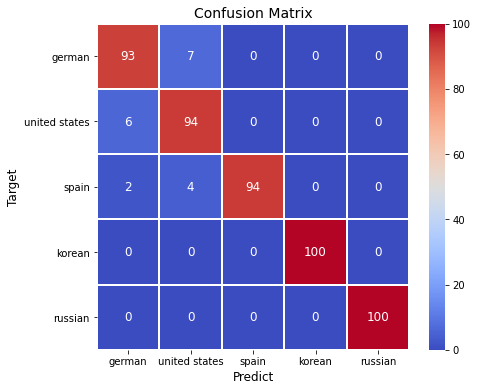

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cm = confusion_matrix(y_true=test_guesses["target"], y_pred=test_guesses["pred"], labels=list(range(len(classes))))
sns.heatmap(cm, annot=cm, fmt='', cmap="coolwarm", annot_kws={"fontsize": 12}, 
            linewidths=1, linecolor='white', ax=ax)

ax.set_title("Confusion Matrix", fontsize=14)
ax.set_xticklabels(classes)
ax.set_yticklabels(classes, rotation='horizontal')
ax.set_xlabel("Predict", fontsize=12)
ax.set_ylabel("Target", fontsize=12)
plt.show()

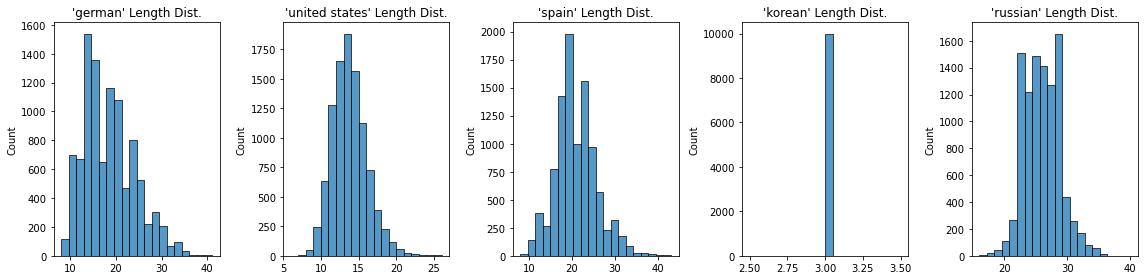

In [27]:
# Seems like model classify the names by length name?
data_dict = {k: [] for k in range(len(train_dataset.labels_stoi))}
for data, label in zip(train_dataset.datas, train_dataset.labels):
    data_dict[label].append(len(data))

fig, axes = plt.subplots(1, 5, figsize=(16, 4))
for ax, label in zip(axes.flatten(), data_dict):
    sns.histplot(data=data_dict[label], bins=20, ax=ax)
    ax.set_title(f"'{classes[label]}' Length Dist.")
plt.tight_layout()
plt.show()

---

# Language Modeling with RNN

In [47]:
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
    
class CustomDataset2(Dataset):
    def __init__(self, path, fmt="\t", pad_idx=1, vocab_stoi=None, labels_stoi=None):
        # read files
        with Path(path).open(mode="r", encoding="utf-8") as file:
            datas = file.readlines()
        datas = [line.strip().lower().split(fmt) for line in datas]
        datas, labels = list(zip(*datas))
        datas = [list(d) for d in datas]  # split all tokens into single character
        self.pad_idx = pad_idx
        
        if (vocab_stoi is None) and (labels_stoi is None):
            self.vocab_stoi = defaultdict()           # dictionary
            self.vocab_stoi["<unk>"] = 0
            self.vocab_stoi["<pad>"] = self.pad_idx   # 1
        
            self.labels_stoi = defaultdict()  
            labels_unique = ["german", "united states", "spain", "korean", "russian"]
            for i, label in enumerate(labels_unique):
                self.labels_stoi[label] = i
        else:
            self.vocab_stoi = vocab_stoi
            self.labels_stoi = labels_stoi
        
        # create index
        for name in datas:
            for letter in name:
                letter = letter.lower()
                if self.vocab_stoi.get(letter) is None:
                    self.vocab_stoi[letter] = len(self.vocab_stoi)
        self.vocab_len = len(self.vocab_stoi)
        self.vector_matrix = torch.eye(self.vocab_len)
        
        # change string to numeric numbers
        datas = [list(map(self.vocab_stoi.get, name)) for name in datas]
        labels = list(map(self.labels_stoi.get, labels))
        
        self.datas = datas
        self.labels = labels
        self.classes = list(self.labels_stoi)
        self.vocab_itos = {v: k for k, v in self.vocab_stoi.items()}
        
    def __getitem__(self, index):
        # return the matched index data
        return self.datas[index], self.labels[index]
        
    def __len__(self):
        # length of dataset
        return len(self.datas)
    
    def custom_collate_fn(self, data):
        """
        data = [
            self.__getitem__(i) for i in range(batch_size)
        ]
        """
        # [(data1, label1), (data2, label2), ...] -> (data1, data2, ...), (label1, label2, ...)
        
        datas, labels = list(zip(*data))
        max_len = max([len(name) for name in datas])
        # pad all idx
        datas = [name + [self.pad_idx]*(max_len - len(name)) if len(name) < max_len else name for name in datas]
        return torch.LongTensor(datas), torch.LongTensor(labels)

In [48]:
path_txt = "./data/names/names_{}.tsv"
batch_size = 128
train_dataset = CustomDataset2(path_txt.format("train"), fmt="\t")
test_dataset = CustomDataset2(path_txt.format("test"), fmt="\t", 
                             vocab_stoi=train_dataset.vocab_stoi,
                             labels_stoi=train_dataset.labels_stoi)

train_loader = DataLoader(dataset=train_dataset,
                          collate_fn=train_dataset.custom_collate_fn,
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         collate_fn=test_dataset.custom_collate_fn,
                         batch_size=batch_size, 
                         shuffle=False)

## Embeddings

In [49]:
data, label = next(iter(train_loader))
embedding_layer = nn.Embedding(train_dataset.vocab_len, 20)  # (222, 20)
print(f"Data size = {data.size()}")  # (B, longest_token_length)
print(f"After Embedding Size = {embedding_layer(data).size()}")  # (B, longest_token_length, embedding_size)

Data size = torch.Size([128, 33])
After Embedding Size = torch.Size([128, 33, 20])


## RNN Model

In [50]:
class Network2(nn.Module):
    def __init__(self, vocab_len, emb_size, hidden_size, output_size, num_layers):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(vocab_len, emb_size)
        self.lstm_layer = nn.LSTM(emb_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # forward propagation
        # x: (B, T) 
        # emb: (B, T, E)
        emb = self.embedding_layer(x)
        outputs, (hiddens, cells) = self.lstm_layer(emb)
        
        # outputs: (B, T, H)
        # hiddens: (num_layer, B, H)
        # cells: (num_layer, B, H)
        last_hidden = hiddens[-1]  # (B, H)
        o = self.linear(last_hidden)
        
        return o

## Train Model

In [34]:
torch.manual_seed(777)
torch.cuda.manual_seed(777)

device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_len = train_dataset.vocab_len
emb_size = 20
hidden_size = 300
output_size = len(train_dataset.classes)
num_layers = 2

model = Network2(vocab_len, emb_size, hidden_size, output_size, num_layers).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

n_step = 10
print_step = 300
best_accuracy = 0
for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    train(model, train_loader, loss_function, optimizer, print_step, device)
    test_loss, test_accuracy = validation(model, test_loader, loss_function, device)
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "./states/best_model-namecls-emb.pt")

[Step] 1/10
 [Training Step]
 - [0.00%] train loss: 1.6146
 - [76.80%] train loss: 0.3920
 [Validation Step]
 - test loss: 1.1823 test accuracy: 87.40 %
[Step] 2/10
 [Training Step]
 - [0.00%] train loss: 0.2305
 - [76.80%] train loss: 0.2975
 [Validation Step]
 - test loss: 0.6619 test accuracy: 91.80 %
[Step] 3/10
 [Training Step]
 - [0.00%] train loss: 0.2617
 - [76.80%] train loss: 0.0956
 [Validation Step]
 - test loss: 0.4144 test accuracy: 95.80 %
[Step] 4/10
 [Training Step]
 - [0.00%] train loss: 0.0824
 - [76.80%] train loss: 0.0958
 [Validation Step]
 - test loss: 0.2237 test accuracy: 98.00 %
[Step] 5/10
 [Training Step]
 - [0.00%] train loss: 0.0510
 - [76.80%] train loss: 0.0528
 [Validation Step]
 - test loss: 0.1429 test accuracy: 99.20 %
[Step] 6/10
 [Training Step]
 - [0.00%] train loss: 0.0203
 - [76.80%] train loss: 0.0389
 [Validation Step]
 - test loss: 0.1292 test accuracy: 99.20 %
[Step] 7/10
 [Training Step]
 - [0.00%] train loss: 0.0356
 - [76.80%] train loss:

In [51]:
model = Network2(vocab_len, emb_size, hidden_size, output_size, num_layers)
model.load_state_dict(torch.load("./states/best_model-namecls-emb.pt", map_location="cpu"))
vocab = train_dataset.vocab_stoi
classes = train_dataset.classes
test_guesses = get_test_result(model, test_loader)

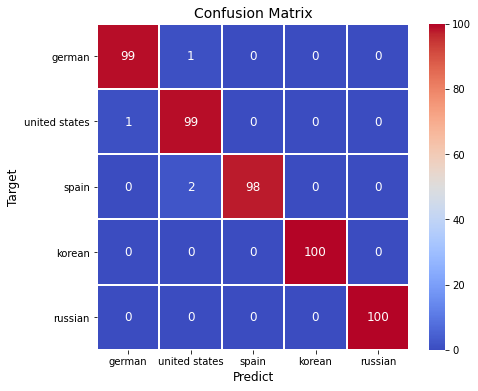

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cm = confusion_matrix(y_true=test_guesses["target"], y_pred=test_guesses["pred"], labels=list(range(len(classes))))
sns.heatmap(cm, annot=cm, fmt='', cmap="coolwarm", annot_kws={"fontsize": 12}, 
            linewidths=1, linecolor='white', ax=ax)

ax.set_title("Confusion Matrix", fontsize=14)
ax.set_xticklabels(classes)
ax.set_yticklabels(classes, rotation='horizontal')
ax.set_xlabel("Predict", fontsize=12)
ax.set_ylabel("Target", fontsize=12)
plt.show()

In [53]:
def preprocessing(text, vocab):
    temp = []
    for x in list(text):
        if vocab.get(x) is None:
            temp.append(vocab["<unk>"])
        else:
            temp.append(vocab[x])

    idx = torch.LongTensor(temp)
    return idx.unsqueeze(0)

In [55]:
# seems like the task dataset it too simple that cannot generalize all name
predict(model, vocab, classes)

Insert Name:  장지수


Prediction: russian
Probabilities: 
  german = 0.0141
  united states = 0.0634
  spain = 0.4264
  korean = 0.0540
  russian = 0.4420
